# Coordinate Transform

In [1]:
import os
from pathlib import Path

cwd = Path(os.getcwd())
log_dir = cwd / "../local/log/1121/asc/经纬度定位"
output_path = log_dir / "raw.csv"

## Data Loading

In [2]:
import re
from typing import Mapping, NamedTuple

import pandas as pd

KEY_VALUE_PATTERN = re.compile(
    r"(?P<key>\w+): (?P<value>-?\d*(?:\.\d*)?)"
)
INS_POSITIONS: Mapping[str, tuple[float, float]] = {
    "1": (545.96, 121.59),
    # "2": (548.20, 115.70),
    "3": (546.05, 109.74),
    "4": (544.34, 103.75),
    "5": (544.01, 91.73),
    "6": (544.30, 79.80),
    "7": (544.28, 67.69),
    "8": (562.15, 130.49),
    "9": (610.01, 138.30),
    "10": (630.20, 130.52),
    "11": (653.99, 138.23),
    "12": (669.99, 130.54),
    "13": (690.01, 138.20),
    "14": (705.77, 130.46),
    "15": (730.05, 130.46),
    "16": (588.03, 109.62),
    "17": (588.03, 97.63),
    "18": (587.94, 85.65),
    "19": (602.05, 66.98),
    # "20": (601.91, 89.10),
    "21": (745.09, 109.51),
    "22": (744.95, 91.81),
}


class DataRow(NamedTuple):
    # log_file: str
    lon: float
    lat: float
    alt: float
    ins_x: float
    ins_y: float


rows: list[DataRow] = []

for dir_entry in log_dir.iterdir():

    if not dir_entry.is_file() or not dir_entry.name.endswith(".log"):
        continue

    file_name = dir_entry.name
    log_number = file_name.split(".")[0][2:]
    if log_number not in INS_POSITIONS:
        print(f'Skipped "{file_name}".')
        continue

    # print(f'Processing "{dir_entry.name}"...')

    latitude_data: list[float] = []
    longitude_data: list[float] = []
    altitude_data: list[float] = []

    with open(dir_entry, "r", encoding="utf-8") as file:
        for line in file:
            if not line.startswith("$BYINS"):
                continue
            fields = line.strip().split(",")
            if len(fields) < 36:
                continue
            # -- latitude_integrated, ... --
            latitude_data.append(float(fields[4]))
            longitude_data.append(float(fields[5]))
            altitude_data.append(float(fields[6]))
            # -- latitude, ... --
            # latitude_data.append(float(fields[33]))
            # longitude_data.append(float(fields[32]))
            # altitude_data.append(float(fields[34]))

    ins_position = INS_POSITIONS[log_number]
    mean_latitude = sum(latitude_data) / len(latitude_data)
    mean_longitude = sum(longitude_data) / len(longitude_data)
    mean_altitude = sum(altitude_data) / len(altitude_data)
    rows.append(
        DataRow(
            # log_file=sheet_name,
            lon=mean_longitude,
            lat=mean_latitude,
            alt=mean_altitude,
            ins_x=ins_position[0],
            ins_y=ins_position[1],
        )
    )

df_data = pd.DataFrame(
    rows,
    columns="lon lat alt ins_x ins_y".split(),
)
df_data.to_csv(
    output_path,
    index=False,
    header=False,
)

print(f'Data saved to "{output_path.relative_to(cwd)}".')

Skipped "日志2.log".
Skipped "日志20.log".
Data saved to "..\local\log\1121\asc\经纬度定位\raw.csv".


## Compute Transform Matrix

经纬度海拔坐标：

$$
p_{\text{Global}} = (\varphi,\lambda,h)^{\text{T}} \\
\varphi = \mathrm{Latitude} \times \frac{\pi}{180},\;
\lambda = \mathrm{Longitude} \times \frac{\pi}{180},\;
h = \mathrm{Altitude}
$$

ENU 坐标：

$$
p_{\text{ENU}} = (e,n,u)^{\text{T}}
$$

堆场坐标：

$$
p = (x,y,z)^{\text{T}}
$$

参考点坐标：

$$
p_0 = (x_0,y_0,z_0)^{\text{T}}
\,/\,
(\varphi_0,\lambda_0,h_0)^{\text{T}}
\,/\,
(e_0,n_0,u_0)^{\text{T}}
$$

相对坐标：

$$
p^{\prime} = (x^{\prime},y^{\prime},z^{\prime})^{\text{T}}
    = (x-x_0,y-y_0,z-z_0)^{\text{T}}
$$

使用二次函数拟合相对坐标与 ENU 坐标的关系：

$$
p^{\prime} = f(e,n,u) \\
f(e,n,u) = (f_1(e,n,u),f_2(e,n,u),f_3(e,n,u))^{\text{T}} \\
f_i(e,n,u) = a_{i,1} e^2 + a_{i,2} n^2 + a_{i,3} u^2 
           + a_{i,4} e n + a_{i,5} n u + a_{i,6} u e
           + a_{i,7} e   + a_{i,8} n   + a_{i,9} u
           + a_{i,10}
           ,\, i\in\{1,2,3\}
$$

化为广义线性模型：

$$
\tilde{f} = (\tilde{f}_1,\tilde{f}_2,\tilde{f}_3)^{\text{T}} \\
\tilde{f}_i(e,n,u,e^2,n^2,u^2,en,nu,ue) = f_i(e,n,u),\, i\in\{1,2,3\}
$$

使用最小二乘求解

$$
\min\quad \sum_{j} \Vert
    \tilde{f}(e_j,n_j,u_j,e_j^2,n_j^2,u_j^2,e_j n_j,n_j u_j,u_j e_j) - p_j
    \Vert_2^2
$$

得到系数 $a_{i,k}\,(i=1,2,3;\;k=1,2,\cdots,10)$ ，再带回求出 $p=(x,y,z)^{\text{T}}$ .


LLA origin:
[120.24106883  36.01042015  10.21364995]
INS origin:
[618.86  110.135]
ECEF origin:
[-2603578.98284767  4466030.17638175]
solution:
[[ 8.20278043e-01 -5.68435652e-01]
 [ 6.59378980e-01  7.12998020e-01]
 [-1.24918382e+01  1.48961297e+01]
 [ 1.08120452e-04 -1.00225940e-03]
 [ 2.20810066e-03  1.03807785e-02]
 [ 1.02549933e+02  3.36015621e+02]
 [ 1.03990193e-03 -4.40583705e-03]
 [-9.99648162e-01 -3.94203528e+00]
 [-2.03881673e-01  1.02869056e+00]
 [ 2.39049508e-01  2.83610542e+00]]
residuals:
[0.92568881 5.62922664]
rank:
10
singular_values:
[2.66190723e+04 8.09623106e+03 1.77390385e+03 2.76268248e+02
 8.41410982e+01 7.16245494e+00 3.42381846e+00 1.48622564e+00
 1.00016910e-01 5.01514864e-03]


,ins_x,ins_x_pred,ins_y,ins_y_pred,dis
7,588.03,587.775879,109.62,108.645869,1.006732
6,730.05,730.240165,130.46,129.473775,1.004392
3,669.99,670.049660,130.54,131.258146,0.720620
16,544.30,544.627044,79.80,80.410772,0.692820
0,545.96,545.819258,121.59,120.916844,0.687711
15,544.01,544.019404,91.73,92.417173,0.687237
12,744.95,745.217971,91.81,92.385235,0.634590
11,745.09,744.648399,109.51,109.072199,0.621837
8,588.03,587.896408,97.63,97.025228,0.619351
5,705.77,705.929152,130.46,130.992846,0.556106


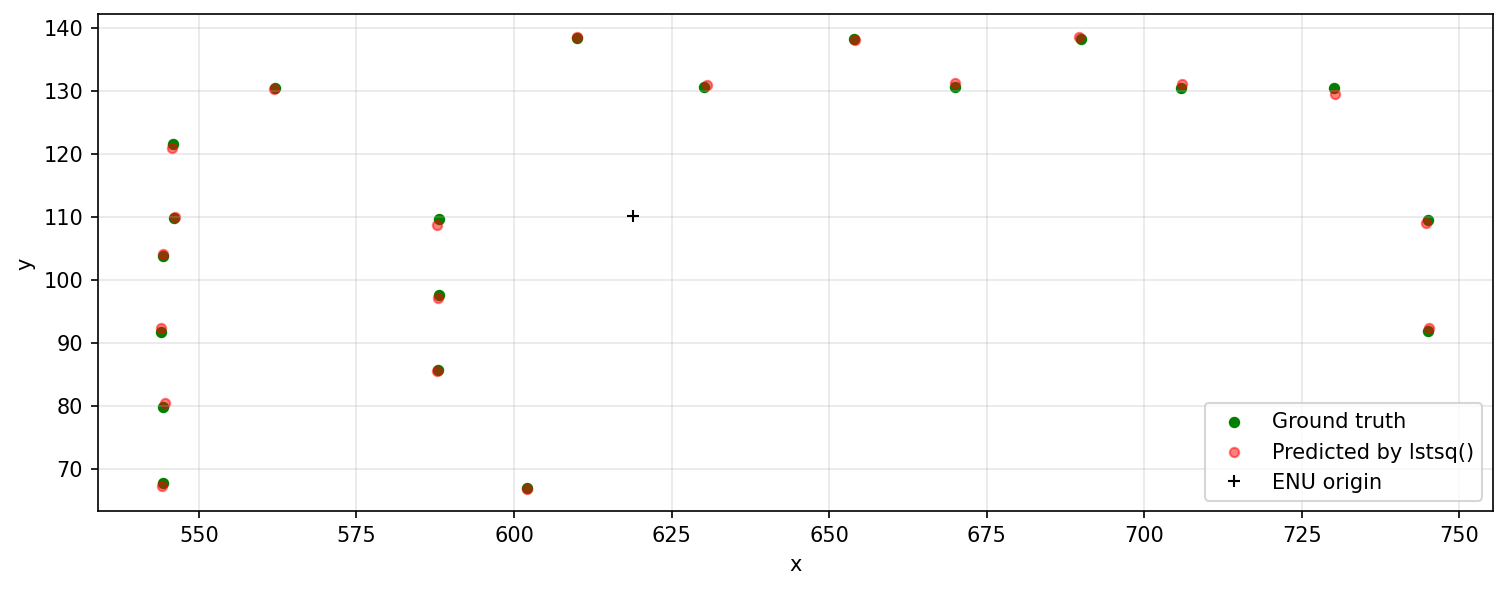

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = len(df_data)

lon = df_data["lon"].to_numpy()
lat = df_data["lat"].to_numpy()
alt = df_data["alt"].to_numpy()
ins_x = df_data["ins_x"].to_numpy()
ins_y = df_data["ins_y"].to_numpy()

lon_rad = lon * np.pi / 180
lat_rad = lat * np.pi / 180
ref_lon_rad = np.mean(lon_rad)
ref_lat_rad = np.mean(lat_rad)
ref_alt = np.mean(alt)
ref_ins_x = np.mean(ins_x)
ref_ins_y = np.mean(ins_y)
# ref_lon_rad = lon_rad[0]
# ref_lat_rad = lat_rad[0]
# ref_alt = alt[0]
# ref_ins_x = ins_x[0]
# ref_ins_y = ins_y[0]
# ref_lon_rad = 120.234438 * np.pi / 180
# ref_lat_rad = 36.009284 * np.pi / 180
# ref_alt = np.mean(alt)
# ref_ins_x = 0
# ref_ins_y = 0
print("LLA origin:")
print(np.array([
    ref_lon_rad * 180 / np.pi,
    ref_lat_rad * 180 / np.pi,
    ref_alt,
]))
print("INS origin:")
print(np.array([ref_ins_x, ref_ins_y]))

r_long = 6378137
r_short = 6356752.3142
e: np.float64 = np.sqrt(1 - (r_short / r_long) ** 2)

N_mean: np.ndarray = r_long / np.sqrt(1 - e ** 2 * np.sin(ref_lat_rad))
ecef_x0: np.float64 = (N_mean + ref_alt) * \
    np.cos(ref_lat_rad) * np.cos(ref_lon_rad)
ecef_y0: np.float64 = (N_mean + ref_alt) * \
    np.cos(ref_lat_rad) * np.sin(ref_lon_rad)
ecef_z0: np.float64 = (N_mean * (r_long / r_short) **
                       2 + ref_alt) * np.sin(ref_lat_rad)
print("ECEF origin:")
print(np.array([ecef_x0, ecef_y0]))

N: np.ndarray = r_long / np.sqrt(1 - e ** 2 * np.sin(lat_rad))
ecef_dx = (N + alt) * np.cos(lat_rad) * np.cos(lon_rad) - ecef_x0
ecef_dy = (N + alt) * np.cos(lat_rad) * np.sin(lon_rad) - ecef_y0
ecef_dz = (N * (r_long / r_short) ** 2 + alt) * np.sin(lat_rad) - ecef_z0

enu_x = -np.sin(lon_rad) * ecef_dx + np.cos(lon_rad) * ecef_dy
enu_y = -np.cos(lon_rad) * np.sin(lat_rad) * ecef_dx \
    - np.sin(lon_rad) * np.sin(lat_rad) * ecef_dy \
    + np.cos(lat_rad) * ecef_dz
enu_z = np.cos(lon_rad) * np.cos(lat_rad) * ecef_dx \
    + np.sin(lon_rad) * np.cos(lat_rad) * ecef_dy \
    + np.sin(lat_rad) * ecef_dz

A = np.hstack([
    enu_x.reshape((n_samples, 1)),
    enu_y.reshape((n_samples, 1)),
    enu_z.reshape((n_samples, 1)),
    (enu_x ** 2).reshape((n_samples, 1)),
    (enu_y ** 2).reshape((n_samples, 1)),
    (enu_z ** 2).reshape((n_samples, 1)),
    (enu_x * enu_y).reshape((n_samples, 1)),
    (enu_y * enu_z).reshape((n_samples, 1)),
    (enu_z * enu_x).reshape((n_samples, 1)),
    # (enu_x * enu_y * enu_z).reshape((n_samples, 1)),
    np.ones((n_samples, 1)),
])
b = np.vstack([
    ins_x - ref_ins_x,
    ins_y - ref_ins_y,
]).T
# print(A.shape)
# print(b.shape)
(
    solution,
    residuals,
    rank,
    singular_values,
) = np.linalg.lstsq(A, b)
print("solution:")
print(solution)
print("residuals:")
print(residuals)
print("rank:")
print(rank)
print("singular_values:")
print(singular_values)

df_comp = df_data.copy()
df_comp[["ins_x_pred", "ins_y_pred"]] = A @ solution \
    + np.array([[ref_ins_x, ref_ins_y]] * n_samples)
df_comp["dis"] = np.sqrt(
    (df_comp["ins_x_pred"] - df_comp["ins_x"]) ** 2
    + (df_comp["ins_y_pred"] - df_comp["ins_y"]) ** 2
)

fig = plt.figure(figsize=(12, 12), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()
df_comp.plot.scatter(x="ins_x", y="ins_y", c="g", ax=ax, label="Ground truth")
df_comp.plot.scatter(x="ins_x_pred", y="ins_y_pred", c="r", alpha=0.5,
                     ax=ax, label="Predicted by lstsq()")
ax.plot(ref_ins_x, ref_ins_y, "k+", label="ENU origin")

alpha = -37 * np.pi / 180
x = ref_ins_x + enu_x * np.cos(alpha) - enu_y * np.sin(alpha)
y = ref_ins_y + enu_x * np.sin(alpha) + enu_y * np.cos(alpha)
# ax.plot(x, y, "bx", label="Predicted by rotation")

ax.set(
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend()
ax.grid(alpha=0.3)

df_comp.sort_values(by="dis", ascending=False)[[
    "ins_x",
    "ins_x_pred",
    "ins_y",
    "ins_y_pred",
    "dis"
]]